# Restaurant Recommender

## Table of Contents

1. [Plan of attack](#Plan-of-attack)<br>
2. [Loading data](#Loading)<br>
3. [Initial FunkSVD Model](#Initial-FunkSVD-Model)<br>

### <a class="anchor" id="Plan-of-attack">Plan of Attack </a>

- Clean
    - [x] Date to date column 
    - [x] Select only users who've had more than 20 reviews (should be a few thousand)
    - [x] Output to pickle/json
    - [x] Duplicates
    - [x] NaNs
    - [x] Outlying dates/stars
- EDA -  for writeup
    - [ ] Most reviewed restaurants, can we cut out restaurants with few reviews and come back to them later?
    - [ ] Most prolific users (e.g. "The biggest 5 reviewers posted more reviews than the bottom X")
    - [x] Plot restaurants on heatmap and on clustered point map in prep for knowledge based search.
    - [x] How many times were restaurants reviewed by the same person more than once.  Keep the most recent review?
- FunkSVD
    - [x] Train test
    - [x] Exectute
    - [x] Score on unseen data
    - [x] Use [numba version](https://github.com/gbolmier/funk-svd) of FunkSVD to speed up runtime
    - [x] gridsearch a few alpha, k and iterations to plot the changing RMSE
    - [x] discuss skew (unbalanced ratings data) and sparcity
- Edge cases
    - [x] Cold start for users
    - [ ] Cold start for restaurants (no content based)
- Recommendations
    - [ ] Best predicted ratings from FunkSVD for powerusers
    - [ ] Top in area for new users
    - [ ] Possibly implement knowledge based on extra features of restaurants
    - [ ] Add ability to plot top-n restaurants on graph (just need to sort `info` bit)
    - [ ] By proximity to person, can leave this as a next-step
    - [ ] Filtered by cuisine, can leave this as a next-step
    - [ ] Compare FunkSVD to just predicting the mean of the existing ratings.  Would a simple method be better here?

### <a class="anchor" id="Loading"> Loading Data </a>

Data from [Yelp](https://www.kaggle.com/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_business.json)

In [398]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba
import folium
from folium import Choropleth, Circle, Marker, Popup
from folium.plugins import HeatMap, MarkerCluster
import math

In [215]:
def pick_lines_and_load(line):
    '''
    Args:
    Returns:
    '''
    line_json = json.loads(line)
    line = dict( [k,v] for k,v in line_json.items() if k in columns_to_keep) 
    return line
    
def read_in_json(filepath):
    '''The Yelp json files are one json per row, so 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines()
        data = list(map(pick_lines_and_load, data)) 

    return pd.DataFrame(data)

def get_file_structure(filepath):
    '''Gets the file structure of the input file by reading a single line 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines(1)
        data = list(map(json.loads, data)) 

    return pd.DataFrame(data)

In [216]:
get_file_structure('../../../YelpData/yelp_academic_dataset_business.json')
columns_to_keep = ['business_id','name','city','latitude','longitude','review_count','categories']

In [217]:
df_businesses = read_in_json('../../../YelpData/yelp_academic_dataset_business.json')



In [218]:
df_businesses.head()

,business_id,name,city,latitude,longitude,review_count,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,35.462724,-80.852612,36,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,33.569404,-111.890264,4,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,Montreal,45.479984,-73.580070,5,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,North Las Vegas,36.219728,-115.127725,3,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,Mesa,33.428065,-111.726648,26,"Home Services, Plumbing, Electricians, Handyma..."


In [219]:
# How many nulls in each columns?
df_businesses.isna().mean()

business_id     0.000000
name            0.000000
city            0.000000
latitude        0.000000
longitude       0.000000
review_count    0.000000
categories      0.002502
dtype: float64

In [220]:
# Drop businesses without a category
df_businesses.dropna(subset = ['categories'], inplace=True)
df_businesses.isna().mean()

business_id     0.0
name            0.0
city            0.0
latitude        0.0
longitude       0.0
review_count    0.0
categories      0.0
dtype: float64

In [221]:
categories = df_businesses.categories.str.split(',').explode().str.strip()

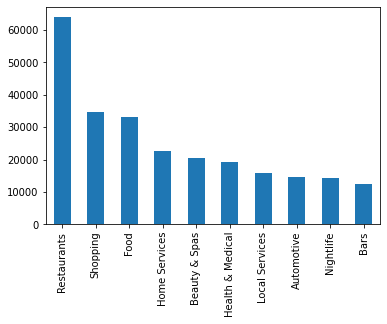

In [222]:
categories.value_counts()[:10].plot(kind='bar');

In [223]:
# Keep only business which contain Restaurant in their category list
df_businesses = df_businesses[df_businesses.categories.str.split(',').apply(lambda x: 'Restaurants' in x)]
df_businesses.shape

(19456, 7)

In [224]:
df_businesses_toronto = df_businesses[df_businesses.city == 'Toronto']

In [346]:
# Create a base map
m_1 = folium.Map(location=[43.716805,-79.400696], tiles='cartodbpositron', zoom_start=11)

# Add a heatmap to the base map
HeatMap(data=df_businesses_toronto[['latitude', 'longitude']], radius=14).add_to(m_1)

# Display the map
m_1

In [225]:
review_filepath = '../../../YelpData/yelp_academic_dataset_review.json'
get_file_structure(review_filepath)
columns_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','date']

In [226]:
df_reviews = read_in_json(review_filepath)

In [227]:
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,2017-01-14 21:56:57


In [228]:
df_reviews_city = df_reviews.merge(df_businesses[['business_id','city']], on='business_id')

In [229]:
city_counts = df_reviews_city.groupby('city').review_id.count()

In [230]:
city_counts.sort_values(ascending = False)

city
Las Vegas                368047
Phoenix                  139547
Toronto                  125432
Scottsdale                63989
Charlotte                 58330
                          ...  
Black Earth                   3
RŽpentigny                    3
Saint-Basile-le-Grand         3
Bellvue                       3
Coteau-Du-Lac                 3
Name: review_id, Length: 537, dtype: int64

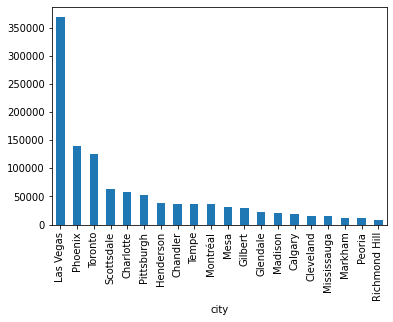

In [231]:
city_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [232]:
user_counts = df_reviews_city.groupby('city').user_id.nunique()

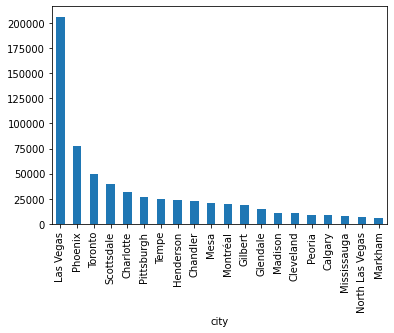

In [233]:
user_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [234]:
toronto_reviews = df_reviews_city[df_reviews_city.city == 'Toronto']

In [235]:
toronto_reviews.shape

(125432, 9)

In [236]:
user_counts = toronto_reviews.groupby('user_id').review_id.count()

In [237]:
user_counts[user_counts > 20] = 20

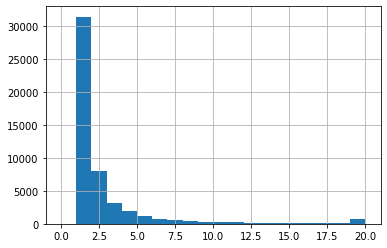

In [238]:
user_counts.hist(bins = np.arange(21));

In [239]:
toronto_reviews.business_id.nunique()

2707

In [240]:
toronto_reviews.user_id.nunique()

49549

In [241]:
# Change datetime column from object to date
toronto_reviews['year'] = pd.to_datetime(toronto_reviews.date).dt.year
toronto_reviews['date'] = pd.to_datetime(toronto_reviews.date).dt.date


/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


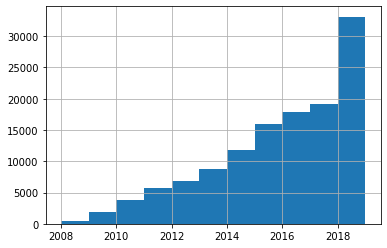

In [242]:
toronto_reviews.year.hist(bins=np.arange(2008,2020))

In [458]:
toronto_reviews.year.value_counts()

2017    19097
2018    18368
2016    17955
2015    15966
2019    14750
2014    11821
2013     8788
2012     6806
2011     5668
2010     3799
2009     1910
2008      504
Name: year, dtype: int64

In [243]:
toronto_reviews_sub = toronto_reviews[toronto_reviews.year>2014]


In [244]:
user_counts = toronto_reviews_sub[toronto_reviews_sub.year<2019].groupby('user_id').review_id.count()


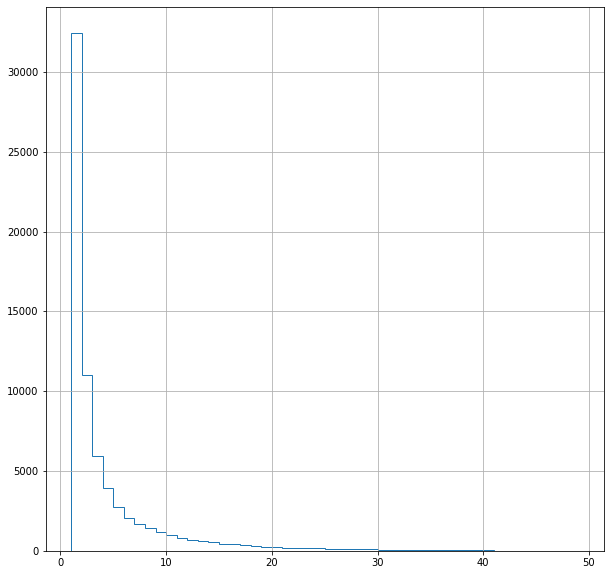

In [245]:
# How are the reviews made up?  The vast majority come from users who reviews just once.
# These users won't be much use for SVD.  We can see that ~10_000 users have more than 
# who have reviewed 5 or more times, I will use just these ones to begin with.
user_counts.hist(histtype='step',cumulative=-1, bins=np.arange(1,50), figsize = (10,10))

number_of_reviews = []

for n in range(0,51,5):
    top_users = user_counts[user_counts>=n].index
    number_of_reviews.append([n,toronto_reviews_sub[(toronto_reviews_sub.year<2019) & (toronto_reviews_sub.user_id.isin(top_users))].shape[0]])

number_of_reviews = np.array(number_of_reviews)
    

In [246]:
number_of_reviews

array([[    0, 71386],
       [    5, 28995],
       [   10, 17941],
       [   15, 11709],
       [   20,  8029],
       [   25,  5712],
       [   30,  4304],
       [   35,  3302],
       [   40,  2387],
       [   45,  1806],
       [   50,  1524]])

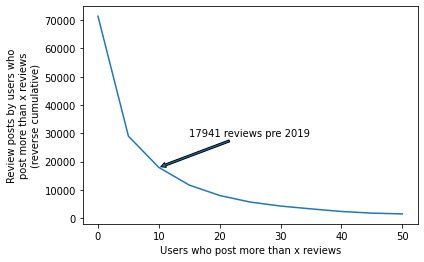

In [247]:
plt.plot(number_of_reviews[:,0],number_of_reviews[:,1])
plt.ylabel('Review posts by users who\npost more than x reviews\n(reverse cumulative)')
plt.xlabel('Users who post more than x reviews');
# Who is defined as a power_user
keep = 10
keep_id = int(keep/5)
plt.annotate(s = '{} reviews pre 2019'.format(number_of_reviews[keep_id,1])
             , xy = (number_of_reviews[keep_id,0],number_of_reviews[keep_id,1])
             , xytext = (number_of_reviews[keep_id+1,0],number_of_reviews[keep_id-1,1])
             , arrowprops = {'arrowstyle': 'simple'});


In [248]:
# Cut the review df to just those users who've made 20 or more reviews between 2014-2018 inc
top_users = user_counts[user_counts>=keep]
toronto_reviews_sub = toronto_reviews_sub[toronto_reviews_sub.user_id.isin(top_users.index)]

In [249]:
print('{} power users with {} reviews (2015-19) for {} restaurants'.format(len(top_users), toronto_reviews_sub.shape[0],  toronto_reviews_sub.business_id.nunique()))


1019 power users with 20390 reviews (2015-19) for 1943 restaurants


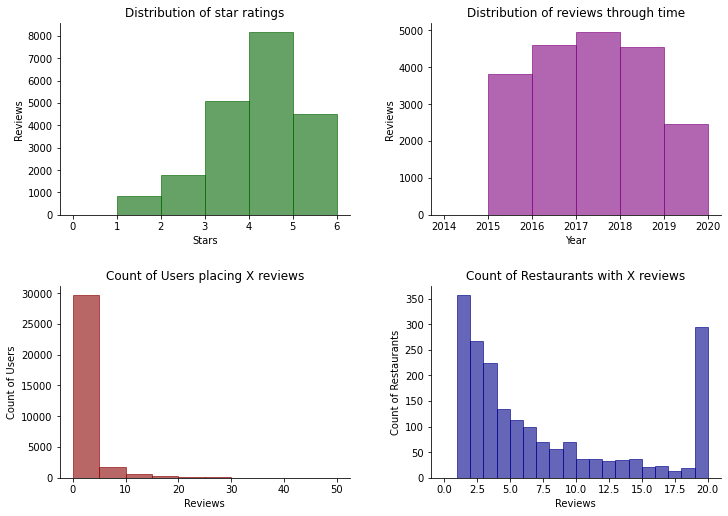

In [877]:
def format_chart(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig,ax = plt.subplots(2,2, figsize = (11,8))
fig.tight_layout(pad = 5.0)

toronto_reviews_sub.stars.hist(bins=range(7), color = 'darkgreen', ax=ax[0][0], alpha=0.6, edgeColor = 'darkgreen')
format_chart(ax[0][0], 'Distribution of star ratings','Stars','Reviews')

toronto_reviews_sub.year.hist(bins = np.arange(2014,2021,1), ax=ax[0][1] , alpha = 0.6, color = 'purple', edgeColor = 'purple')
format_chart(ax[0][1], 'Distribution of reviews through time','Year','Reviews')

user_counts.hist(bins = np.arange(0,51,5), ax=ax[1][0], color = 'darkred', alpha = 0.6, edgeColor = 'darkred')
format_chart(ax[1][0], 'Count of Users placing X reviews','Reviews','Count of Users')

business_counts = toronto_reviews_sub.groupby('business_id').review_id.count()
business_counts[business_counts > 20] = 20      

business_counts.hist(bins = np.arange(21), ax=ax[1][1], color = 'darkblue', alpha = 0.6, edgeColor = 'darkblue')
format_chart(ax[1][1], 'Count of Restaurants with X reviews','Reviews','Count of Restaurants')

#### Encode business_id, user_id and review_id as integer keys
TODO: to future proof I'll need to pass all new data through this mapper function with the corresponding coded_dict

In [145]:
# def id_mapper(df, column, coded_dict=dict()):
#     '''Takes arbirtrary keys in a column, of any type, and encodes them as int
#     Args:
#         df - (pd.DataFrame) Dataframe of input values
#         column - (string) Column name to encode
#         coded_dict - (optional dict()) existing dict to use/add-to
#     Returns:
#         column_encoded - (list) the encoded values
#         coded_dict - (dict) the dictionary to keep for future encodings
#     '''
#     coded_dict = dict()
#     cter = 1
#     column_encoded = []
    
#     for val in df[column]:
#         if val not in coded_dict:
#             coded_dict[val] = cter
#             cter +=1
        
#         column_encoded.append(coded_dict[val])
#     return column_encoded, coded_dict

In [141]:
# toronto_reviews_sub['review_id'] = id_mapper(toronto_reviews_sub,'review_id')[0]
# toronto_reviews_sub['user_id'] = id_mapper(toronto_reviews_sub,'user_id')[0]
# toronto_reviews_sub['business_id'] = id_mapper(toronto_reviews_sub,'business_id')[0]

# toronto_reviews_sub.head()

review_id               int64
user_id                 int64
business_id             int64
stars                   int64
useful                  int64
funny                   int64
cool                    int64
date           datetime64[ns]
city                   object
year                    int64
dtype: object

In [253]:
toronto_reviews_sub.to_json('toronto_reviews_sub.json', orient='records')
df_businesses_toronto.to_json('businesses_toronto.json', orient='records')

### <a class="anchor" id="Initial-FunkSVD-Model"> Initial FunkSVD Model </a>


#### Re-read in data

In [254]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba

In [255]:
toronto_reviews_sub = pd.read_json('toronto_reviews_sub.json', orient='records')
df_businesses_toronto = pd.read_json('businesses_toronto.json', orient='records')

#### Split train and test

In [256]:
toronto_reviews_train = toronto_reviews_sub[toronto_reviews_sub.year <2019]
toronto_reviews_test = toronto_reviews_sub[toronto_reviews_sub.year == 2019]

Drop all but the most recent review from each user for each restaurant - thinking being that their most recent review will affect their future behaviour more

In [257]:
print('Before, # reviews: ',len(toronto_reviews_train))
toronto_reviews_train = toronto_reviews_train[~toronto_reviews_train.duplicated(subset=['user_id','business_id'],keep='last')]
print('After,  # reviews: ', len(toronto_reviews_train))


Before, # reviews:  17941
After,  # reviews:  17157


Create user_by_restaurant table

In [258]:
toronto_reviews_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
0,0bG4SvQx1-YQf8S5vi-JXQ,foCj2hDfH84WGwglfAbDVA,4m_hApwQ054v3ue_OxFmGw,3,1,0,0,2016-11-09,Toronto,2016
1,F-rEm9n8EsMCDrKuac1LEw,DTl0SQ_9ApT_YhIcppwqgw,4m_hApwQ054v3ue_OxFmGw,4,0,0,0,2015-07-04,Toronto,2015
2,uOpzjADQ_b50ZuRlnQ-j3w,JLvoH5EfNResDJBeQUIqCA,4m_hApwQ054v3ue_OxFmGw,3,0,0,1,2016-10-01,Toronto,2016
3,BTnPU97pFs6MaeF9IOea2A,gGtM52jNBzsP_sGCSIRz0A,4m_hApwQ054v3ue_OxFmGw,4,0,0,0,2017-08-29,Toronto,2017
4,WsPA489NRqoTd2CZiOACmw,X-VOe5bzT9EJu_L_Bt0nLQ,4m_hApwQ054v3ue_OxFmGw,5,1,0,0,2015-02-24,Toronto,2015


In [16]:
user_by_restaurant = toronto_reviews_train[['user_id','business_id','stars']] \
                        .groupby(['user_id', 'business_id'])['stars'] \
                        .max().unstack()


In [19]:
user_by_restaurant

business_id,1,2,3,4,5,6,7,8,9,10,...,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def FunkSVD(ratings_mat, latent_features=10, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, rxs as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    rx_mat - (numpy array) a latent feature by restaurant matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]  # number of rows in the matrix
    n_rxs = ratings_mat.shape[1] # number of rx in the matrix
    num_ratings = ratings_mat.size  # total number of ratings in the matrix
    
    # initialize the user and rx matrices with random values
    user_mat = np.random.rand(n_users,latent_features)# user matrix filled with random values of shape user x latent 
    rx_mat = np.random.rand(latent_features,n_rxs)# rx matrix filled with random values of shape latent x rx
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # timeit
    start = time.time()
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations\t| Mean Squared Error\t| ETA ")
    
    # for each iteration
    for i in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-rx pair
        for u in range(n_users):
            for m in range(n_rxs):
                # if the rating exists
                if np.isfinite(ratings_mat[u,m]):

                    # compute the error as the actual minus the dot product of the user and rx latent features
                    err = ratings_mat[u,m]-np.dot(user_mat[u,:],rx_mat[:,m])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    user_mat[u,:] = user_mat[u,:] + learning_rate * 2 * err * rx_mat[:,m].T
                    rx_mat[:,m] = rx_mat[:,m] + learning_rate * 2 * err * user_mat[u,:].T
        # Update time
        ETA = (time.time()-start)/(i+1)*(iters-i-1)
        ETA_string = '{:.0f}m{:.0f}s'.format(ETA//60,ETA%60)
                    
                    
        # print results for iteration
        print("%d \t\t |%f \t\t| %s" % (i+1, sse_accum / num_ratings, ETA_string))
        
    return user_mat, rx_mat 





In [668]:
user_mat, rx_mat = FunkSVD(np.matrix(user_by_restaurant), latent_features=10, learning_rate=0.005, iters=25)# use your function with 4 latent features, lr of 0.005 and 10 iterations


Optimization Statistics
Iterations	| Mean Squared Error	| ETA 
1 		|0.017085 		| 1m54s
2 		|0.010352 		| 1m47s
3 		|0.008540 		| 1m42s
4 		|0.007685 		| 1m37s
5 		|0.007164 		| 1m32s
6 		|0.006791 		| 1m27s
7 		|0.006495 		| 1m23s
8 		|0.006244 		| 1m18s
9 		|0.006021 		| 1m14s
10 		|0.005818 		| 1m9s
11 		|0.005628 		| 1m5s
12 		|0.005448 		| 1m0s
13 		|0.005275 		| 0m55s
14 		|0.005108 		| 0m51s
15 		|0.004946 		| 0m46s
16 		|0.004789 		| 0m42s
17 		|0.004635 		| 0m37s
18 		|0.004486 		| 0m32s
19 		|0.004340 		| 0m28s
20 		|0.004199 		| 0m23s
21 		|0.004061 		| 0m18s
22 		|0.003928 		| 0m14s
23 		|0.003799 		| 0m9s
24 		|0.003675 		| 0m5s
25 		|0.003555 		| 0m0s


In [665]:
def predict_rating(user_matrix, rx_matrix, user_id, rx_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    rx_matrix - latent factor by rx matrix
    user_id - the user_id from the reviews df
    rx_id - the rx_id according the rxs df
    
    OUTPUT:
    pred - the predicted rating for user_id-rx_id according to FunkSVD
    '''
    # Use the training data to create a series of users and rxs that matches the ordering in training data
    rx_ids = toronto_reviews_train.business_id.sort_values().unique()
    user_ids = toronto_reviews_train.user_id.sort_values().unique()
    m_id = np.where(rx_ids==rx_id)[0][0]
    u_id = np.where(user_ids==user_id)[0][0]

    # User row and rx Column
    row = user_matrix[u_id,:]
    column = rx_matrix[:,m_id]
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(row,column)
    
    return pred

In [666]:


toronto_reviews_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
397248,NnB7PoqJPrlzCl3ayQjvIw,Kj9cFO70zZOQorN0mgeLWA,Z2QohwGZOSqutdlU2xDWJw,4.0,0,0,1,2015-01-01,Toronto,2015
362610,dQqSOfur1w463gS0FW14Sg,x2o4DyS9DUUTD2S0vwlDCQ,yU4zevCwPAQIMb73smTHog,3.0,0,0,1,2015-01-01,Toronto,2015
248033,MXnL6VPVDtlFOYsfVQjqaQ,c9NbdAJy9eOGGc_i3UKuKQ,qo9JoIB9iZxGl-KQGDzEWw,3.0,0,0,0,2015-01-01,Toronto,2015
105048,A1oLgG6m5dT-wcoTNSY73A,FREeRQtjdJU83AFtdETBBw,kZh-0f291AiayMgs1EqwIQ,3.0,1,0,1,2015-01-01,Toronto,2015
390059,180bxHHNe94oCROK54Cyvg,G-9ujgKmc1J2k7HSqXszsw,UsKmYp0m8VYWM96tkGm2vQ,4.0,1,0,0,2015-01-01,Toronto,2015


In [670]:
print(predict_rating(user_mat, rx_mat, 'Kj9cFO70zZOQorN0mgeLWA', 'Z2QohwGZOSqutdlU2xDWJw'))
print(predict_rating(user_mat, rx_mat, 'c9NbdAJy9eOGGc_i3UKuKQ', 'qo9JoIB9iZxGl-KQGDzEWw'))

3.4406092689803893
2.6805337680762538


In [809]:
def validation_comparison(val_df, user_mat=user_mat, rx_mat=rx_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    rx_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 5 x 5 grid with counts for actual vs predicted values
    '''
        
    val_users = np.array(val_df['user_id'])
    val_rxs = np.array(val_df['business_id'])
    val_ratings = np.array(val_df['stars'])
    
    sse = 0
    num_rated = 0
    preds, acts = [], []
    actual_v_pred = np.zeros((5,5))
    for idx in range(len(val_users)):
        try:
            pred = predict_rating(user_mat, rx_mat, val_users[idx], val_rxs[idx])
            # Cap prediction at 1-5
            pred = np.min(np.max(pred,1),5)
            sse += (val_ratings[idx] - pred)**2
            num_rated+=1
            preds.append(pred)
            acts.append(val_ratings[idx])
            actual_v_pred[int(val_ratings[idx]-1), int(round(pred)-1)]+=1
        
        except:
            continue
    
    rmse = np.sqrt(sse/num_rated)
    perc_rated = num_rated/len(val_users)
    return rmse, perc_rated, actual_v_pred, preds, acts

In [810]:
# How well did we do?
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(toronto_reviews_test)
print(rmse, perc_rated)

ZeroDivisionError: division by zero

In [ ]:
#sns.heatmap(actual_v_pred/(actual_v_pred.sum(axis=1)[:, np.newaxis]+1E-6), annot=True, fmt='.0%')
sns.heatmap(actual_v_pred, annot=True, fmt='.0f')
plt.xticks(np.arange(5), np.arange(1,6));
plt.yticks(np.arange(5), np.arange(1,6));
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values\n(%age gives percent of actual values\nin each predicted value)");

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (12,6))

ax[0].hist(acts, alpha=.5, label='actual', bins=range(8))
ax[0].hist(np.round(preds), alpha=.5, label='predicted (rounded)', bins=range(8))

ax[1].hist(acts, alpha=.5, label='actual', bins=range(8))
ax[1].hist(preds, alpha=.5, label='predicted (not rounded)', bins=range(8), color='g')

ax[0].legend(loc=2, prop={'size': 10})
ax[1].legend(loc=2, prop={'size': 10})

ax[0].set_xlabel('Rating')
ax[1].set_xlabel('Rating')

plt.title('Predicted vs. Actual Rating');

## Combine this hist with the heatmap for a beaut plot

In [ ]:
#user_mat2, rx_mat2 = FunkSVD(np.matrix(user_by_restaurant), latent_features=25, learning_rate=0.0025, iters=250)# use your function with 4 latent features, lr of 0.005 and 10 iterations


In [ ]:
rmse2, perc_rated2, actual_v_pred2, preds2, acts2 = validation_comparison(toronto_reviews_test, user_mat2, rx_mat2)


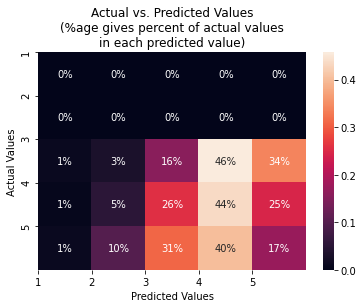

In [722]:
sns.heatmap(actual_v_pred2/(actual_v_pred2.sum(axis=1)[:, np.newaxis]+1E-6), annot=True, fmt='.0%')
plt.xticks(np.arange(5), np.arange(1,6));
plt.yticks(np.arange(5), np.arange(1,6));
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values\n(%age gives percent of actual values\nin each predicted value)");

In [737]:
dat = actual_v_pred2/(actual_v_pred2.sum(axis=1)[:, np.newaxis]+1E-6)
dat
#sns.jointplot()

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01098901, 0.03296703, 0.15824176, 0.45714286, 0.34065934],
       [0.00648508, 0.05317769, 0.25810636, 0.43709468, 0.24513619],
       [0.01106195, 0.10176991, 0.30973451, 0.40265487, 0.17477876]])

In [142]:
plt.figure(figsize=(8,8))
plt.hist(acts2, density=True, alpha=.5, label='actual', bins=range(8));
plt.hist(preds2, density=True, alpha=.5, label='predicted', bins=range(8));
plt.legend(loc=2, prop={'size': 15});
plt.xlabel('Rating');
plt.title('Predicted vs. Actual Rating');

NameError: name 'acts2' is not defined

<Figure size 576x576 with 0 Axes>

Thoughts:
- rounding before histogramming, would we round the predictions and does it make a difference to the RMSE.
- essentially, 5 only has 0.5 width to gain from (unless scores go over 5, of which there are a few), whereas the other numbers have 1.0 width
- different scoring metric, perhaps "did it get those restaurants they actually rated in 2019 in the right order?"
- check the value rating thing, wondering if it's losing anything above 5.
- think about doing value rating in a matrix instead of a loop, would need to get test user-rx matrix with same columns and rows as train. That evaluation is taking way too long

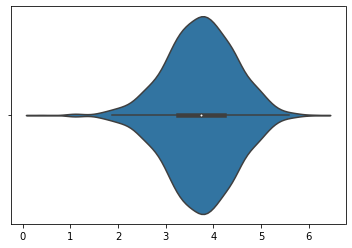

In [733]:
sns.violinplot(preds);

## Attempt to `numba` my FunkSVD

In [9]:
from numba import jit

@numba.jit(nopython=True)
def NumbaFunkSVD(ratings_mat, latent_features=10, learning_rate=0.0001, iters=100, print_every=1):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, rxs as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    rx_mat - (numpy array) a latent feature by restaurant matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]  # number of rows in the matrix
    n_rxs = ratings_mat.shape[1] # number of rx in the matrix
    num_ratings = ratings_mat.size  # total number of ratings in the matrix
    
    # initialize the user and rx matrices with random values
    user_mat = np.random.rand(n_users,latent_features)# user matrix filled with random values of shape user x latent 
    rx_mat = np.random.rand(latent_features,n_rxs)# rx matrix filled with random values of shape latent x rx
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations\t| Mean Squared Error\t")
    
    # for each iteration
    for i in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-rx pair
        for u in range(n_users):
            for m in range(n_rxs):
                # if the rating exists
                if np.isfinite(ratings_mat[u,m]):

                    # compute the error as the actual minus the dot product of the user and rx latent features
                    err = ratings_mat[u,m]-np.dot(user_mat[u,:],rx_mat[:,m])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    user_mat[u,:] = user_mat[u,:] + learning_rate * 2 * err * rx_mat[:,m].T
                    rx_mat[:,m] = rx_mat[:,m] + learning_rate * 2 * err * user_mat[u,:].T
                    
                    
        # print results for iteration
        
        if (i+1)/print_every == round((i+1)/print_every):
            print(i+1,'\t\t|', round(sse_accum / num_ratings,5))
        
    return user_mat, rx_mat 

In [10]:
# Get starttime
start = time.time()
# Run this function
user_mat, rx_mat = NumbaFunkSVD(np.matrix(user_by_restaurant), latent_features=10, learning_rate=0.005, iters=25, print_every = 5) # use your function with 4 latent features, lr of 0.005 and 10 iterations
# Print the runtime
print('Time: {:.2f}s'.format(time.time()-start))


<ipython-input-9-2242707cfaeb>:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  err = ratings_mat[u,m]-np.dot(user_mat[u,:],rx_mat[:,m])


Optimization Statistics
Iterations	| Mean Squared Error	
5 		| 0.00714
10 		| 0.00584
15 		| 0.00499
20 		| 0.00426
25 		| 0.00365
Time: 1.38s


In [11]:
user_ids = toronto_reviews_train.user_id.sort_values().unique()
rx_ids = toronto_reviews_train.business_id.sort_values().unique()

@numba.jit(nopython=True)
def Numba_predict_rating(user_matrix, rx_matrix, user_id, rx_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    rx_matrix - latent factor by rx matrix
    user_id - the user_id from the reviews df
    rx_id - the rx_id according the rxs df
    
    OUTPUT:
    pred - the predicted rating for user_id-rx_id according to FunkSVD
    '''
    # Use the training data to create a series of users and rxs that matches the ordering in training data
    m_id = np.argwhere(rx_ids==rx_id)[0][0]
    u_id = np.argwhere(user_ids==user_id)[0][0]

    # User row and rx Column
    row = user_matrix[u_id,:]
    column = rx_matrix[:,m_id]
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(row,column)
    
    return pred

In [12]:
Numba_predict_rating(user_mat, rx_mat, 1, 2)

<ipython-input-11-de4c288351c6>:24: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  pred = np.dot(row,column)


3.9794659440130653

In [94]:
type(np.array(user_by_restaurant))

numpy.ndarray

In [33]:
val_users = np.array(toronto_reviews_test['user_id'])
val_rxs = np.array(toronto_reviews_test['business_id'])
val_ratings = np.array(toronto_reviews_test['stars'])
toronto_reviews_test_array = np.array(toronto_reviews_test[['user_id','business_id','stars']])

@numba.jit(nopython=True)
def Numba_validation_comparison(val_df, user_mat=user_mat, rx_mat=rx_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    rx_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 5 x 5 grid with counts for actual vs predicted values
    '''
        
    #val_users = np.array(val_df['user_id'])
    #val_rxs = np.array(val_df['business_id'])
    #val_ratings = np.array(val_df['stars'])
    
    sse = 0
    num_rated = 0
    preds = [-1]
    acts = [-1]
    actual_v_pred = np.zeros((5,5))
    for idx in range(len(val_users)):
        try:
            #print(idx)
            pred = Numba_predict_rating(user_mat, rx_mat, val_users[idx], val_rxs[idx])
#             # Cap prediction at 1-5
#             pred = min(max(pred,1),5)
#             sse += (val_ratings[idx] - pred)**2
#             num_rated+=1
#             preds.append(pred)
#             acts.append(val_ratings[idx])
#             actual_v_pred[int(val_ratings[idx]-1), int(round(pred)-1)]+=1
        
        except:
            pass
    
#     rmse = np.sqrt(sse/num_rated)
#     perc_rated = num_rated/len(val_users)
    return sse#, perc_rated, actual_v_pred, preds, acts


In [34]:
pred = Numba_predict_rating(user_mat, rx_mat, val_users[1], val_rxs[1])
pred

4.283926928214435

In [ ]:
#rmse, perc_rated, actual_v_pred, preds, acts = Numba_validation_comparison(toronto_reviews_test_array, user_mat, rx_mat)
Numba_validation_comparison(toronto_reviews_test_array, user_mat, rx_mat)


In [151]:
toronto_reviews_train

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
0,1,1,1,4,0,0,1,2015-01-01,Toronto,2015
1,2,2,2,3,0,0,1,2015-01-01,Toronto,2015
2,3,3,3,3,0,0,0,2015-01-01,Toronto,2015
3,4,4,4,3,1,0,1,2015-01-01,Toronto,2015
4,5,5,5,4,1,0,0,2015-01-01,Toronto,2015
...,...,...,...,...,...,...,...,...,...,...
17936,17937,140,1229,4,1,0,0,2018-12-31,Toronto,2018
17937,17938,898,1496,3,0,0,0,2018-12-31,Toronto,2018
17938,17939,379,1648,3,0,0,0,2018-12-31,Toronto,2018
17939,17940,666,508,4,0,0,0,2018-12-31,Toronto,2018


In [62]:
user_by_restaurant_test = toronto_reviews_test[['user_id','business_id','stars']].groupby(['user_id', 'business_id'])['stars'].max().unstack()


In [63]:
user_by_restaurant_test.columns.to_list()

[5,
 9,
 11,
 15,
 16,
 18,
 22,
 24,
 26,
 27,
 28,
 29,
 30,
 35,
 36,
 37,
 38,
 41,
 42,
 43,
 45,
 46,
 47,
 49,
 52,
 53,
 54,
 55,
 59,
 61,
 64,
 65,
 68,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 84,
 89,
 92,
 93,
 95,
 99,
 100,
 101,
 102,
 104,
 105,
 109,
 111,
 112,
 115,
 116,
 119,
 126,
 127,
 128,
 129,
 130,
 133,
 135,
 137,
 139,
 140,
 142,
 143,
 144,
 148,
 149,
 151,
 153,
 159,
 163,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 176,
 178,
 182,
 185,
 186,
 187,
 188,
 189,
 192,
 193,
 194,
 196,
 197,
 200,
 201,
 203,
 205,
 208,
 211,
 214,
 217,
 220,
 222,
 223,
 226,
 227,
 228,
 229,
 230,
 238,
 239,
 240,
 241,
 245,
 247,
 249,
 250,
 252,
 258,
 259,
 261,
 263,
 264,
 265,
 267,
 268,
 269,
 273,
 274,
 275,
 278,
 279,
 280,
 282,
 288,
 291,
 294,
 295,
 296,
 297,
 298,
 305,
 307,
 309,
 310,
 312,
 314,
 316,
 325,
 327,
 328,
 331,
 332,
 336,
 337,
 338,
 339,
 340,
 341,
 344,
 348,
 349,
 350,
 351,
 354,
 360,
 362,


In [64]:
user_by_restaurant_test

business_id,5,9,11,15,16,18,22,24,26,27,...,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Get users in both train and test
shared_users = set(user_by_restaurant.index).intersection(user_by_restaurant_test.index)
# Get restaurants in both train and test
shared_rx = set(user_by_restaurant.columns).intersection(user_by_restaurant_test.columns)
# Create prediction matrix and clip to 1-5
user_by_restaurant_pred = pd.DataFrame(np.dot(user_mat, rx_mat),index = user_by_restaurant.index, columns = user_by_restaurant.columns).clip(1,5)
# Get train_matrix cropped to size of test matrix
user_by_restaurant_pred_cropped = user_by_restaurant_pred.loc[shared_users,shared_rx]
user_by_restaurant_test_cropped = user_by_restaurant_test.loc[shared_users,shared_rx]

# Confirm they have the same order of rows and columns
assert (user_by_restaurant_pred_cropped.index != user_by_restaurant_test_cropped.index).sum() == 0 
assert (user_by_restaurant_pred_cropped.columns != user_by_restaurant_test_cropped.columns).sum() == 0 

#

In [80]:
user_by_restaurant_pred_cropped.head()

business_id,5,9,11,15,16,18,22,24,26,27,...,1787,1788,1789,1790,1791,1792,1794,1796,1797,1799
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.397917,2.656821,3.478941,2.376718,3.426389,2.515621,2.640071,3.137236,3.946933,4.447359,...,3.515627,2.848678,3.718736,3.018800,3.039727,2.949955,2.904047,3.728955,2.574500,4.095586
7,3.653487,2.763208,3.653750,2.862395,2.687739,2.459809,2.565622,2.772682,3.709136,3.147432,...,2.700459,3.022635,3.922777,2.694874,3.077147,2.841841,2.996561,3.121532,3.006782,4.194694
9,3.868041,3.828551,4.629310,2.883003,4.005796,2.687229,4.251308,3.556816,3.745956,5.000000,...,4.616262,3.607707,4.460250,3.800404,4.281436,4.209643,3.523399,4.807171,3.496334,4.848319
10,3.385098,3.513814,4.039545,2.682278,3.571969,2.122613,3.703588,2.870655,3.066050,3.914312,...,3.573992,3.175635,3.928134,3.357572,3.477668,3.492534,3.309707,3.485599,2.973083,3.804164
11,3.785403,2.540333,2.820529,2.399395,3.887522,2.413114,4.381093,3.703611,3.281566,2.385910,...,3.798333,2.225774,4.249432,3.276800,2.566057,3.450594,3.119482,3.583815,3.976614,3.657098


In [81]:
user_by_restaurant_pred.head()

business_id,1,2,3,4,5,6,7,8,9,10,...,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.163705,3.119237,2.837784,1.600128,3.397917,2.954185,2.722202,3.338762,2.656821,2.079179,...,2.949955,3.938888,2.904047,3.319684,3.728955,2.574500,3.034672,4.095586,3.351478,3.645008
2,2.399667,4.010377,3.413835,2.499169,3.746741,4.175248,3.229771,4.879367,3.209371,2.496039,...,3.478031,4.418834,3.644966,3.448013,3.489498,3.625836,2.670285,3.414547,3.910376,3.854970
3,2.616154,3.182182,2.958432,2.655731,3.083656,2.986586,2.418051,2.534610,2.507795,2.395024,...,2.726120,3.656332,2.867342,2.789540,2.859916,2.523375,2.511921,3.396899,2.602887,3.094018
4,3.136740,4.322056,3.595909,2.874217,4.356495,3.947228,3.416692,4.203773,3.446023,3.204973,...,3.786664,4.820909,3.587132,3.635114,4.191103,3.917596,3.523067,4.852161,4.272930,4.463614
5,2.803406,3.328402,3.596008,3.004601,3.482841,3.296395,3.154785,3.130869,2.386297,2.973825,...,3.250145,3.960150,2.967630,3.135234,3.616485,2.775765,3.139237,3.670239,2.971280,2.989101


In [68]:
round(user_by_restaurant_pred_cropped)

business_id,5,9,11,15,16,18,22,24,26,27,...,1787,1788,1789,1790,1791,1792,1794,1796,1797,1799
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,...,4.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0
7,4.0,3.0,4.0,3.0,3.0,2.0,3.0,3.0,4.0,3.0,...,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0
9,4.0,4.0,5.0,3.0,4.0,3.0,4.0,4.0,4.0,6.0,...,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,3.0,5.0
10,3.0,4.0,4.0,3.0,4.0,2.0,4.0,3.0,3.0,4.0,...,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0
11,4.0,3.0,3.0,2.0,4.0,2.0,4.0,4.0,3.0,2.0,...,4.0,2.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,5.0,4.0,5.0,3.0,4.0,3.0,4.0,4.0,5.0,4.0,...,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0
1016,4.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,...,4.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0
1017,4.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,...,3.0,3.0,4.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0


In [11]:
import numpy as np

In [878]:
import recommender
%load_ext autoreload
%autoreload 1
%aimport recommender

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [879]:
rec = recommender.Recommender()

# Create the user-rx matrix
rec.set_user_item_matrix(toronto_reviews_train,'user_id','business_id','stars')
# Fit the FunkSVD
rec.fit(latent_features=10, learning_rate=0.005, iters=25, print_every = 5)


Min rating: 1, max rating: 5


/Users/paulgstubley/Code/GitHub/Udacity/Capstone_Project/recommender.py:49: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  err = ratings_mat[u,m]-np.dot(user_mat[u,:],item_mat[:,m])


Optimization Statistics
Iterations	| Mean Squared Error	
5 		| 0.00716
10 		| 0.00589
15 		| 0.00507
20 		| 0.00435
25 		| 0.00372


In [882]:
out = rec.get_similar_items('U0md3UhNA2123G-vYR9hWQ',20)
recoms = rec.get_item_names(df_businesses_toronto, out, 'name', ['similarity','latitude', 'longitude', 'review_count'])
m = rec.plot_locations(recoms, 'name', 'latitude', 'longitude',info=None, search_string='toronto' )
m

In [881]:
series = rec.predict_ratings_for_user('Kj9cFO70zZOQorN0mgeLWA', 20)
recoms = rec.get_item_names(df_businesses_toronto, series, 'name', ['predicted_rating','latitude', 'longitude', 'review_count'])
m = rec.plot_locations(recoms, 'name', 'latitude', 'longitude', info='predicted_rating',search_string='toronto' )
m

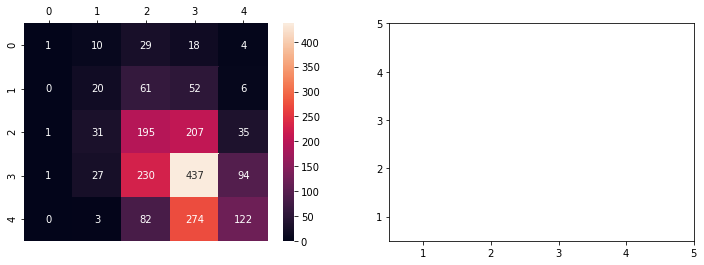

In [581]:
confusion_array = rec.compare_train_to_predictions(toronto_reviews_test)

In [585]:
m.save('map.html')